
# Setup Environment for Prompted Segmentation



In [1]:

!pip install transformers==4.41.1 torch torchvision datasets evaluate accelerate tqdm Pillow matplotlib -q

import torch, os, random, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

print("✅ Torch version:", torch.__version__)
print("✅ CUDA available:", torch.cuda.is_available())

base_dir = Path("/content/data")
(base_dir / "cracks").mkdir(parents=True, exist_ok=True)
(base_dir / "drywall").mkdir(parents=True, exist_ok=True)

print("✅ Environment setup complete.")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 30.9 MB/s eta 0:00:00
✅ Torch version: 2.8.0+cu126
✅ CUDA available: True
✅ Environment setup complete.


# Download and Extract Datasets
Automatically download both Roboflow datasets and extract them into the working directory.

In [2]:
import zipfile, os
from urllib.request import urlretrieve
from pathlib import Path

base_dir = Path("/content/data")
cracks_dir = base_dir / "cracks"
drywall_dir = base_dir / "drywall"
cracks_dir.mkdir(parents=True, exist_ok=True)
drywall_dir.mkdir(parents=True, exist_ok=True)

cracks_url = "https://app.roboflow.com/ds/2Yxh8a6Gm2?key=ryhEZpN9Gl"
drywall_url = "https://app.roboflow.com/ds/4mifwSdARr?key=DdlmUNIDun"

def download_and_unzip(url, dest_dir):
    zip_path = f"{dest_dir}.zip"
    print(f"📦 Downloading dataset to {zip_path} ...")
    urlretrieve(url, zip_path)
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(dest_dir)
    os.remove(zip_path)
    print(f"✅ Unzipped to {dest_dir}")
    for root, dirs, files in os.walk(dest_dir):
        level = root.replace(str(dest_dir), '').count(os.sep)
        indent = ' ' * 4 * level
        print(f"{indent}{Path(root).name}/")
        subindent = ' ' * 4 * (level + 1)
        for f in files[:10]:
            print(f"{subindent}{f}")
        if len(files) > 10:
            print(f"{subindent}... {len(files)-10} more files")

print("Downloading Cracks dataset...")
download_and_unzip(cracks_url, cracks_dir)

print("\nDownloading Drywall dataset...")
download_and_unzip(drywall_url, drywall_dir)

print("\n✅ Both datasets downloaded and unzipped successfully!")


📦 Downloading dataset to /content/data/cracks.zip ...
✅ Unzipped to /content/data/cracks
cracks/
    README.dataset.txt
    README.roboflow.txt
    valid/
        863-dat_png_jpg.rf.d5473b00b4c24b0b86f184f1fc3ad57d.jpg
        crack318_jpg.rf.a020eebb2bc384edb2d4f23e14081ffe.jpg
        896_png_jpg.rf.2bda25b3f2b19ad4f7fa01219a5e83c5.jpg
        2170_jpg.rf.d8f38ec213baf4ae241ddda3bf8d5e56.jpg
        1118-dat_png_jpg.rf.af73ed5d5ca7393e05cf124133ca0d3b.jpg
        crack224_jpg.rf.86d73630496ca509328d517a975ae603.jpg
        616-dat_png_jpg.rf.d30d60aab23de5f95dd4e9c5b1d35f84.jpg
        crack342_jpg.rf.d8cae86acc78ccf3da221c3b377381b4.jpg
        3443_jpg.rf.d6d444e585ad6d3cd925c3732005e4e6.jpg
        291-dat_png_jpg.rf.4c38c1def23a1e506d50dbfa0727b617.jpg
        ... 192 more files
    test/
        2056_jpg.rf.928a893cf37ac90421186251d0112ffb.jpg
        photo_6165758190491385222_y_jpg.rf.4ff6d577796c2cadda2dea409e0bf742.jpg
        _annotations.coco.json
        photo_616575819049

# Convert COCO Annotations to Binary Masks

Generate segmentation masks for:

Cracks → polygon-based masks

Drywall → bounding-box masks
Masks are saved as PNG ({0,255}) matching the dataset requiremen

In [3]:
import json, os
from PIL import Image, ImageDraw
from tqdm import tqdm
from pathlib import Path

def coco_to_polygon_masks(base_dir):
    base_dir = Path(base_dir)
    coco_files = list(base_dir.rglob("_annotations.coco.json"))
    if not coco_files:
        raise FileNotFoundError("❌ No _annotations.coco.json found in cracks dataset.")
    print(f"Found {len(coco_files)} COCO JSON files in {base_dir.name}.")

    for coco_json_path in coco_files:
        with open(coco_json_path, "r") as f:
            data = json.load(f)

        split_folder = Path(coco_json_path).parent
        mask_dir = split_folder / "masks"
        os.makedirs(mask_dir, exist_ok=True)

        id_to_info = {img["id"]: img for img in data["images"]}

        for ann in tqdm(data["annotations"], desc=f"Converting {split_folder.name}"):
            image_info = id_to_info[ann["image_id"]]
            fname = image_info["file_name"]
            width, height = image_info["width"], image_info["height"]
            segs = ann.get("segmentation", [])

            mask = Image.new("L", (width, height), 0)
            draw = ImageDraw.Draw(mask)

            for seg in segs:
                if len(seg) >= 6:
                    polygon = [(seg[i], seg[i + 1]) for i in range(0, len(seg), 2)]
                    draw.polygon(polygon, outline=255, fill=255)

            mask.save(mask_dir / (Path(fname).stem + ".png"))

    print("✅ Cracks masks created successfully.")

def coco_to_bbox_masks(base_dir):
    base_dir = Path(base_dir)
    coco_files = list(base_dir.rglob("_annotations.coco.json"))
    if not coco_files:
        raise FileNotFoundError("❌ No _annotations.coco.json found in drywall dataset.")
    print(f"Found {len(coco_files)} COCO JSON files in {base_dir.name}.")

    for coco_json_path in coco_files:
        with open(coco_json_path, "r") as f:
            data = json.load(f)

        split_folder = Path(coco_json_path).parent
        mask_dir = split_folder / "masks"
        os.makedirs(mask_dir, exist_ok=True)

        id_to_info = {img["id"]: img for img in data["images"]}

        for ann in tqdm(data["annotations"], desc=f"Converting {split_folder.name}"):
            image_info = id_to_info[ann["image_id"]]
            fname = image_info["file_name"]
            width, height = image_info["width"], image_info["height"]
            bbox = ann.get("bbox", None)

            mask = Image.new("L", (width, height), 0)
            draw = ImageDraw.Draw(mask)

            if bbox:
                x, y, w, h = bbox
                draw.rectangle([x, y, x + w, y + h], outline=255, fill=255)

            mask.save(mask_dir / (Path(fname).stem + ".png"))

    print("✅ Drywall masks created successfully.")

print("🔹 Generating Cracks polygon masks...")
coco_to_polygon_masks("/content/data/cracks")

print("\n🔹 Generating Drywall rectangular masks...")
coco_to_bbox_masks("/content/data/drywall")

print("\n✅ All masks created successfully!")


🔹 Generating Cracks polygon masks...
Found 3 COCO JSON files in cracks.


Converting train: 100%|██████████| 8133/8133 [01:08<00:00, 117.89it/s]


✅ Cracks masks created successfully.

🔹 Generating Drywall rectangular masks...
Found 2 COCO JSON files in drywall.


Converting train: 100%|██████████| 1111/1111 [00:03<00:00, 280.65it/s]

✅ Drywall masks created successfully.

✅ All masks created successfully!


# Visualizing Sample Masks

Show random samples from each dataset with:

original image

mask

red overlay visualization


🔹 Showing 3 samples from Cracks (train)


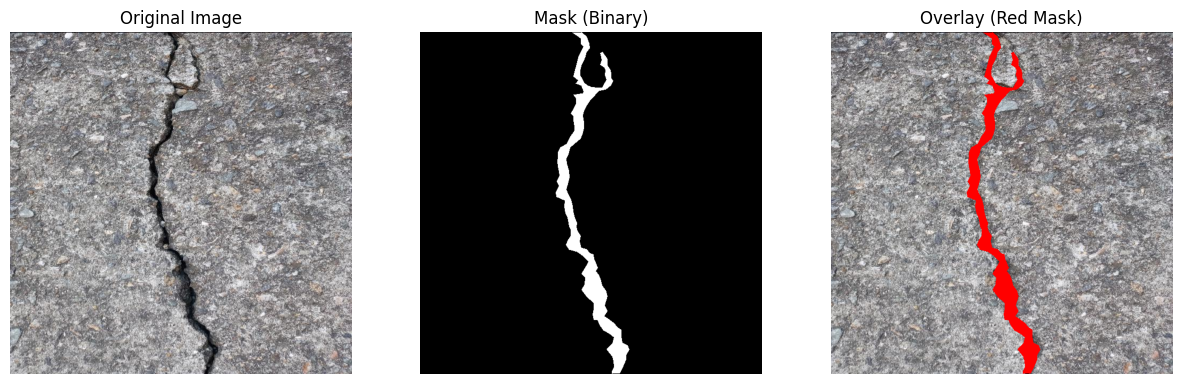

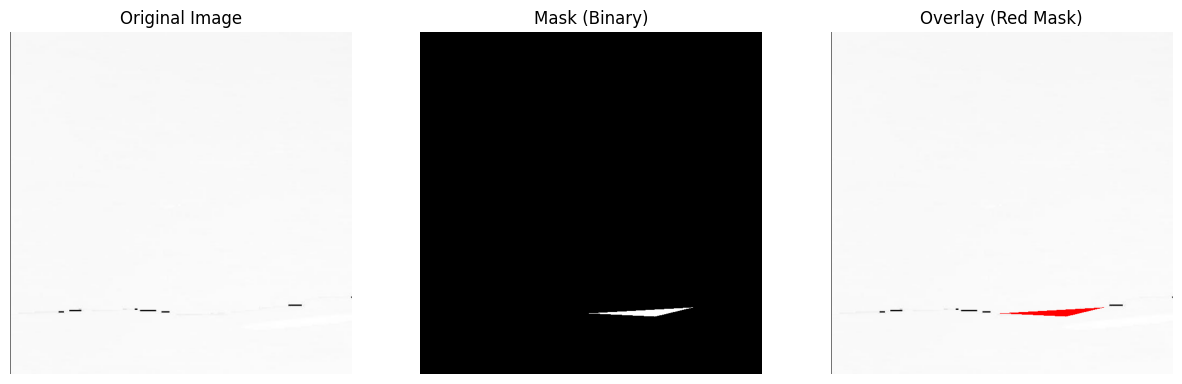

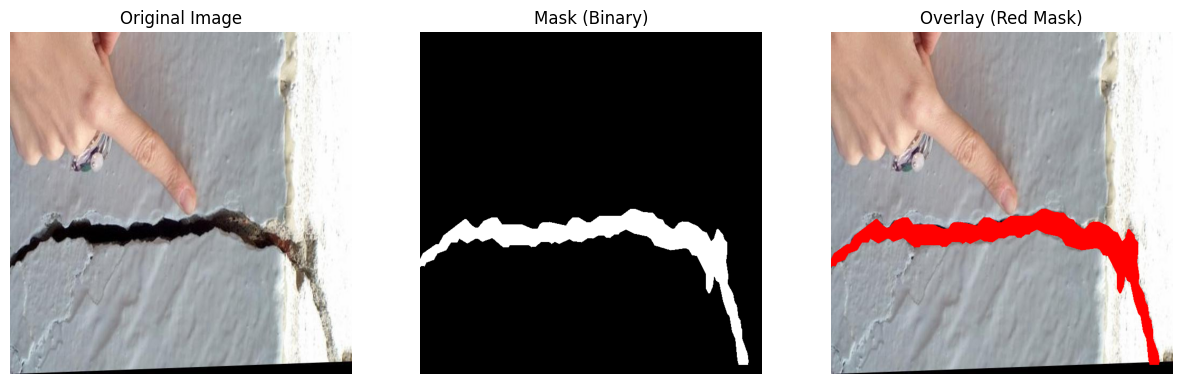


🔹 Showing 3 samples from Drywall (train)


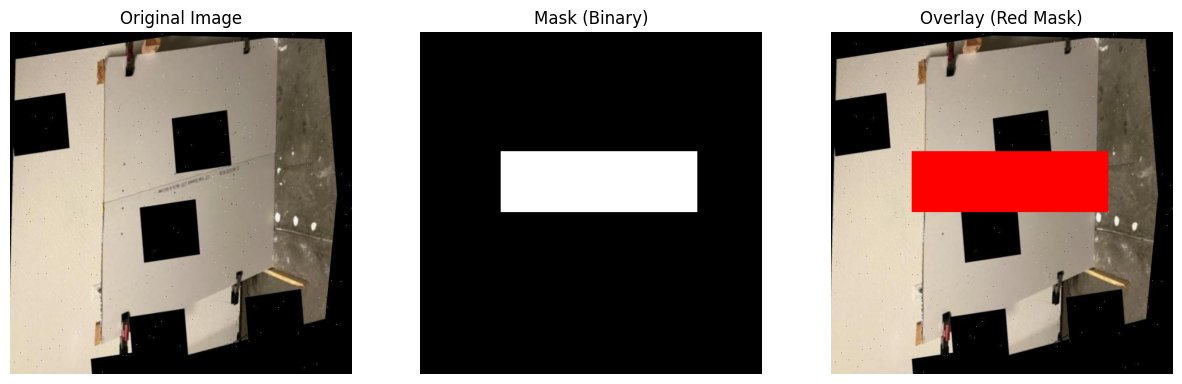

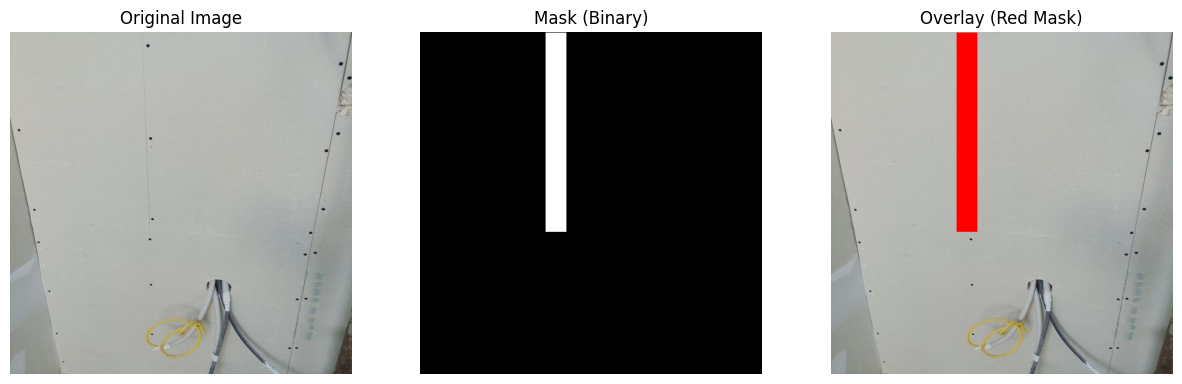

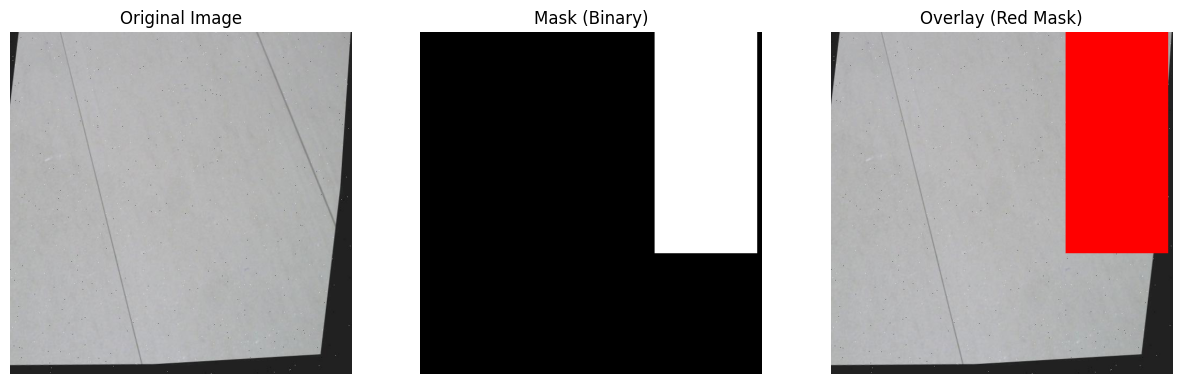

In [4]:

import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pathlib import Path

def show_random_samples(base_dir, split="train", n=3, title="Dataset"):
    img_dir = Path(base_dir) / split
    mask_dir = img_dir / "masks"
    samples = random.sample(list(img_dir.glob("*.jpg")), n)

    print(f"\n🔹 Showing {n} samples from {title} ({split})")
    for img_path in samples:
        mask_path = mask_dir / (img_path.stem + ".png")
        if not mask_path.exists():
            continue

        img = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"))

        overlay = img.copy()
        overlay[mask > 128] = [255, 0, 0]

        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(img)
        ax[0].set_title("Original Image")
        ax[1].imshow(mask, cmap="gray")
        ax[1].set_title("Mask (Binary)")
        ax[2].imshow(overlay)
        ax[2].set_title("Overlay (Red Mask)")
        for a in ax:
            a.axis("off")
        plt.show()

# 🔸 Show Cracks samples
show_random_samples("/content/data/cracks", split="train", n=3, title="Cracks")

# 🔸 Show Drywall samples
show_random_samples("/content/data/drywall", split="train", n=3, title="Drywall")


# Build Prompted Dataset (Image → Mask → Text Prompt)

Create CSV files mapping each image to:

mask_path

corresponding natural-language prompt
Used later for prompt-conditioned training.

In [5]:
import pandas as pd
from pathlib import Path

def build_prompt_dataframe(base_dir, prompt_text, split="train"):
    """Builds dataframe mapping images -> masks -> text prompt."""
    img_dir = Path(base_dir) / split
    mask_dir = img_dir / "masks"
    data = []
    for img_path in img_dir.glob("*.jpg"):
        mask_path = mask_dir / (img_path.stem + ".png")
        if mask_path.exists():
            data.append({
                "image_path": str(img_path),
                "mask_path": str(mask_path),
                "prompt": prompt_text
            })
    df = pd.DataFrame(data)
    return df

# Build dataframes
cracks_train = build_prompt_dataframe("/content/data/cracks", "segment crack", split="train")
cracks_valid = build_prompt_dataframe("/content/data/cracks", "segment crack", split="valid")
drywall_train = build_prompt_dataframe("/content/data/drywall", "segment taping area", split="train")
drywall_valid = build_prompt_dataframe("/content/data/drywall", "segment taping area", split="valid")

# Combine both datasets
train_df = pd.concat([cracks_train, drywall_train], ignore_index=True)
valid_df = pd.concat([cracks_valid, drywall_valid], ignore_index=True)

# Save CSVs
train_df.to_csv("/content/train_prompts.csv", index=False)
valid_df.to_csv("/content/valid_prompts.csv", index=False)

print("✅ Combined prompted dataset created successfully!")
print(f"Train set: {len(train_df)} samples")
print(f"Valid set: {len(valid_df)} samples")

train_df.sample(5)


✅ Combined prompted dataset created successfully!
Train set: 5982 samples
Valid set: 403 samples


,image_path,mask_path,prompt
2020,/content/data/cracks/train/00060_jpg.rf.58bd8c...,/content/data/cracks/train/masks/00060_jpg.rf....,segment crack
189,/content/data/cracks/train/cracking0102109_jpg...,/content/data/cracks/train/masks/cracking01021...,segment crack
2870,/content/data/cracks/train/cracking448_jpg.rf....,/content/data/cracks/train/masks/cracking448_j...,segment crack
940,/content/data/cracks/train/2057_jpg.rf.fe0cbca...,/content/data/cracks/train/masks/2057_jpg.rf.f...,segment crack
2546,/content/data/cracks/train/1066-dat_png_jpg.rf...,/content/data/cracks/train/masks/1066-dat_png_...,segment crack


# Fine-tuning CLIPSeg for Text-Conditioned Segmentation

Load pretrained CLIPSeg and train for segmentation using prompts:

“segment crack”

“segment taping area”

Includes:

dataset class

dataloaders

loss function

full training loop

saving the fine-tuned model

training curve

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/974 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/603M [00:00<?, ?B/s]


🚀 Starting CLIPSeg fine-tuning (final patch)...


Epoch 1/10: 100%|██████████| 2991/2991 [04:57<00:00, 10.07it/s]


Epoch [1/10] - Train Loss: 0.1062 | Val Loss: 0.1704


Epoch 2/10: 100%|██████████| 2991/2991 [04:55<00:00, 10.14it/s]


Epoch [2/10] - Train Loss: 0.0909 | Val Loss: 0.1506


Epoch 3/10: 100%|██████████| 2991/2991 [04:55<00:00, 10.13it/s]


Epoch [3/10] - Train Loss: 0.0847 | Val Loss: 0.1382


Epoch 4/10: 100%|██████████| 2991/2991 [04:57<00:00, 10.06it/s]


Epoch [4/10] - Train Loss: 0.0799 | Val Loss: 0.1393


Epoch 5/10: 100%|██████████| 2991/2991 [04:56<00:00, 10.08it/s]


Epoch [5/10] - Train Loss: 0.0764 | Val Loss: 0.1301


Epoch 6/10: 100%|██████████| 2991/2991 [04:56<00:00, 10.10it/s]


Epoch [6/10] - Train Loss: 0.0733 | Val Loss: 0.1247


Epoch 7/10: 100%|██████████| 2991/2991 [04:57<00:00, 10.06it/s]


Epoch [7/10] - Train Loss: 0.0702 | Val Loss: 0.1271


Epoch 8/10: 100%|██████████| 2991/2991 [04:56<00:00, 10.09it/s]


Epoch [8/10] - Train Loss: 0.0677 | Val Loss: 0.1199


Epoch 9/10: 100%|██████████| 2991/2991 [04:57<00:00, 10.07it/s]


Epoch [9/10] - Train Loss: 0.0655 | Val Loss: 0.1182


Epoch 10/10: 100%|██████████| 2991/2991 [04:55<00:00, 10.12it/s]


Epoch [10/10] - Train Loss: 0.0631 | Val Loss: 0.1160

✅ Model fine-tuned and saved at: /content/clipseg-finetuned


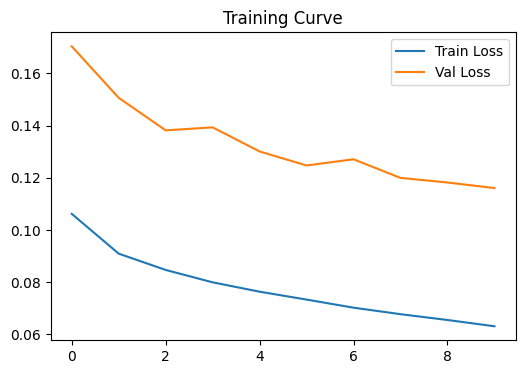

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
from tqdm import tqdm
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence

# Load processor + model
model_name = "CIDAS/clipseg-rd64-refined"
processor = CLIPSegProcessor.from_pretrained(model_name)
model = CLIPSegForImageSegmentation.from_pretrained(model_name)
model = model.to("cuda")

# Resize masks to model output size (352x352)
mask_transform = transforms.Compose([
    transforms.Resize((352, 352)),
    transforms.ToTensor()
])

# Custom Dataset
class PromptedSegmentationDataset(Dataset):
    def __init__(self, csv_path, processor, augment=False):
        self.data = pd.read_csv(csv_path)
        self.processor = processor
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image = Image.open(row["image_path"]).convert("RGB")
        mask = Image.open(row["mask_path"]).convert("L")

        if self.augment and np.random.rand() > 0.5:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
            mask = mask.transpose(Image.FLIP_LEFT_RIGHT)

        inputs = self.processor(
            text=row["prompt"],
            images=image,
            return_tensors="pt"
        )

        mask = mask_transform(mask)
        mask = (mask > 0.5).float()

        return {
            "pixel_values": inputs["pixel_values"].squeeze(0),
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "mask": mask
        }

def collate_fn(batch):
    pixel_values = torch.stack([b["pixel_values"] for b in batch])
    masks = torch.stack([b["mask"] for b in batch])

    input_ids = [b["input_ids"] for b in batch]
    attention_masks = [b["attention_mask"] for b in batch]

    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=0)
    attention_masks_padded = pad_sequence(attention_masks, batch_first=True, padding_value=0)

    return {
        "pixel_values": pixel_values,
        "mask": masks,
        "input_ids": input_ids_padded,
        "attention_mask": attention_masks_padded
    }

# Datasets + Dataloaders
train_dataset = PromptedSegmentationDataset("/content/train_prompts.csv", processor, augment=True)
valid_dataset = PromptedSegmentationDataset("/content/valid_prompts.csv", processor)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=2, collate_fn=collate_fn)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# Training loop
num_epochs = 10
train_losses, val_losses = [], []

print("\n🚀 Starting CLIPSeg fine-tuning (final patch)...")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        pixel_values = batch["pixel_values"].to("cuda")
        input_ids = batch["input_ids"].to("cuda")
        attention_mask = batch["attention_mask"].to("cuda")
        mask_labels = batch["mask"].squeeze(1).to("cuda")  # FIXED ✅

        outputs = model(
            pixel_values=pixel_values,
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=mask_labels
        )

        loss = outputs.loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in valid_loader:
            pixel_values = batch["pixel_values"].to("cuda")
            input_ids = batch["input_ids"].to("cuda")
            attention_mask = batch["attention_mask"].to("cuda")
            mask_labels = batch["mask"].squeeze(1).to("cuda")  # FIXED ✅

            outputs = model(
                pixel_values=pixel_values,
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=mask_labels
            )
            val_loss += outputs.loss.item()

    avg_val_loss = val_loss / len(valid_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

# Save fine-tuned model
save_path = "/content/clipseg-finetuned"
model.save_pretrained(save_path)
processor.save_pretrained(save_path)
print(f"\n✅ Model fine-tuned and saved at: {save_path}")

# Plot training curve
plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Training Curve")
plt.show()


# Initial Evaluation & Visual Predictions

Evaluate the fine-tuned model on both datasets and visualize:

original

ground truth

predicted mask

overlay


🧩 Evaluating prompt: segment crack


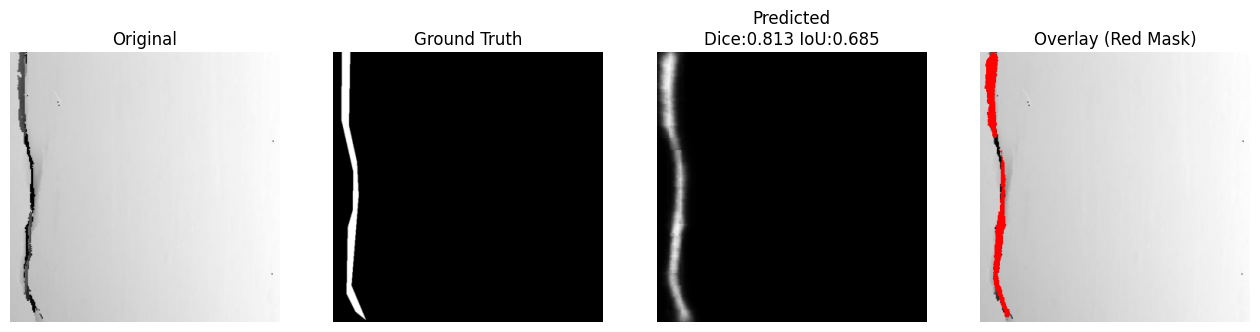

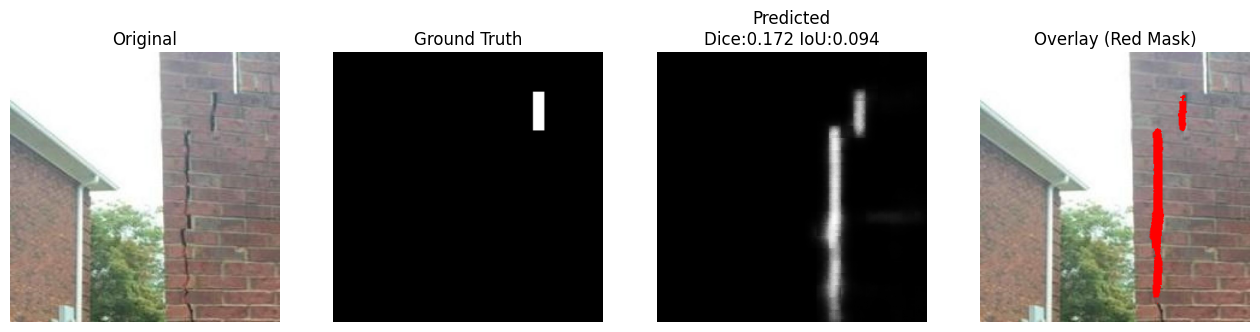


🧩 Evaluating prompt: segment taping area


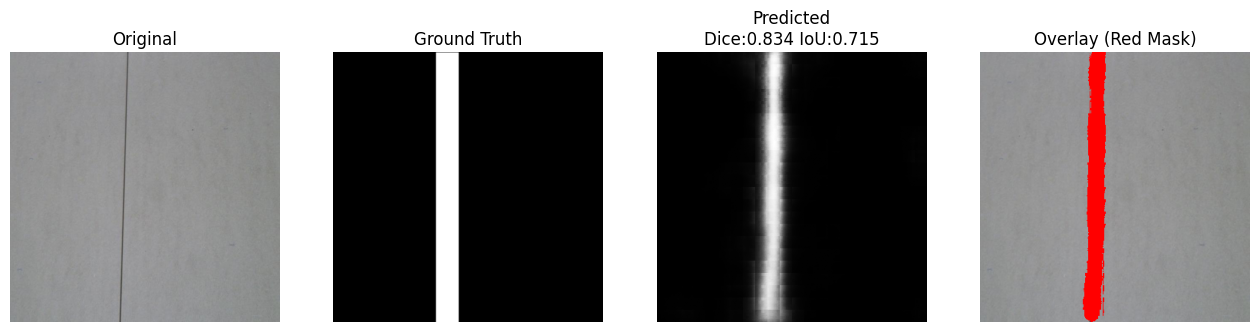

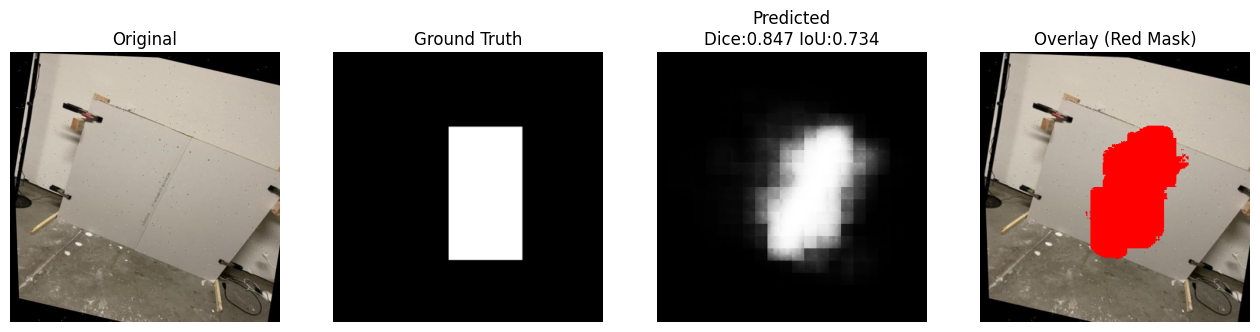

In [13]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from tqdm import tqdm
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
import random
from pathlib import Path

# Load fine-tuned model + processor
model_path = "/content/clipseg-finetuned"
processor = CLIPSegProcessor.from_pretrained(model_path)
model = CLIPSegForImageSegmentation.from_pretrained(model_path).to("cuda").eval()

resize = transforms.Resize((352, 352))

def dice_score(pred, gt):
    pred = pred > 0.5
    gt = gt > 0.5
    inter = (pred & gt).sum()
    union = pred.sum() + gt.sum()
    return (2.0 * inter) / union if union != 0 else 1.0

def miou(pred, gt):
    pred = pred > 0.5
    gt = gt > 0.5
    inter = (pred & gt).sum()
    union = (pred | gt).sum()
    return inter / union if union != 0 else 1.0

def visualize_prediction(image_path, mask_path, prompt):
    image = Image.open(image_path).convert("RGB")
    gt_mask = Image.open(mask_path).convert("L")
    inputs = processor(text=prompt, images=image, return_tensors="pt").to("cuda")

    with torch.no_grad():
        outputs = model(**inputs)
        pred_mask = torch.sigmoid(outputs.logits).cpu().squeeze().numpy()

    gt = np.array(resize(gt_mask)) / 255.0
    pred = pred_mask
    dice = dice_score(pred, gt)
    iou = miou(pred, gt)

    # Overlay prediction
    overlay = np.array(image.resize((352,352))).copy()
    overlay[pred > 0.5] = [255, 0, 0]

    fig, ax = plt.subplots(1, 4, figsize=(16,4))
    ax[0].imshow(image)
    ax[0].set_title("Original")
    ax[1].imshow(gt, cmap="gray")
    ax[1].set_title("Ground Truth")
    ax[2].imshow(pred, cmap="gray")
    ax[2].set_title(f"Predicted\nDice:{dice:.3f} IoU:{iou:.3f}")
    ax[3].imshow(overlay)
    ax[3].set_title("Overlay (Red Mask)")
    for a in ax: a.axis("off")
    plt.show()

# 🔹 Evaluate 2 random cracks + 2 drywall samples
for dataset, prompt in [
    ("/content/data/cracks/valid", "segment crack"),
    ("/content/data/drywall/valid", "segment taping area")
]:
    print(f"\n🧩 Evaluating prompt: {prompt}")
    imgs = list(Path(dataset).glob("*.jpg"))
    random_samples = random.sample(imgs, 2)
    for img_path in random_samples:
        mask_path = Path(dataset)/"masks"/(img_path.stem + ".png")
        visualize_prediction(img_path, mask_path, prompt)


# Rebuilding Crack Masks Using Bounding Box + Dilation

Improve crack mask thickness for fair evaluation:

rebuild masks using bbox + dilation

saves into masks_bbox/

In [8]:
import json, os, cv2
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm import tqdm

base_dir = Path("/content/data/cracks")
kernel = np.ones((7,7), np.uint8)

def rebuild_masks_from_bbox(coco_json_path):
    with open(coco_json_path, "r") as f:
        data = json.load(f)

    split_folder = Path(coco_json_path).parent
    mask_dir = split_folder / "masks_bbox"
    os.makedirs(mask_dir, exist_ok=True)

    id_to_info = {img["id"]: img for img in data["images"]}

    for ann in tqdm(data["annotations"], desc=f"Processing {split_folder.name}"):
        image_info = id_to_info[ann["image_id"]]
        fname = image_info["file_name"]
        width, height = image_info["width"], image_info["height"]
        bbox = ann.get("bbox")
        segs = ann.get("segmentation", [])

        if bbox is None:
            continue

        mask = np.zeros((height, width), dtype=np.uint8)

        # draw polygon if present
        if segs and len(segs[0]) >= 6:
            for seg in segs:
                pts = np.array(seg).reshape(-1, 2).astype(np.int32)
                cv2.fillPoly(mask, [pts], 255)
        else:
            x, y, w, h = map(int, bbox)
            cv2.rectangle(mask, (x, y), (x + w, y + h), 255, -1)

        # dilate to thicken
        mask = cv2.dilate(mask, kernel, iterations=1)

        out_path = mask_dir / (Path(fname).stem + ".png")
        Image.fromarray(mask).save(out_path)

    print(f"✅ {split_folder.name}: {len(list(mask_dir.glob('*.png')))} masks written.")

# find and rebuild for all splits
coco_files = list(base_dir.rglob("_annotations.coco.json"))
if not coco_files:
    raise FileNotFoundError("❌ No COCO annotation files found!")
print(f"Found {len(coco_files)} COCO files:", coco_files)

for coco_json in coco_files:
    rebuild_masks_from_bbox(coco_json)

print("✅ All crack masks rebuilt successfully.")


Found 3 COCO files: [PosixPath('/content/data/cracks/valid/_annotations.coco.json'), PosixPath('/content/data/cracks/test/_annotations.coco.json'), PosixPath('/content/data/cracks/train/_annotations.coco.json')]


Processing valid: 100%|██████████| 372/372 [00:01<00:00, 251.10it/s]


✅ valid: 201 masks written.


Processing test: 100%|██████████| 6/6 [00:00<00:00, 204.21it/s]


✅ test: 4 masks written.


Processing train: 100%|██████████| 8133/8133 [00:35<00:00, 232.26it/s]


✅ train: 5164 masks written.
✅ All crack masks rebuilt successfully.


# Safe Visualization of Improved Crack Masks

Randomly select samples where both image and rebuilt mask exist, then visualize predictions safely.


🔍 Evaluating improved crack masks (safe version)...
✅ Visualizing crack339_jpg.rf.d2720eaa5838f2742007ea7eb6fa8919.jpg


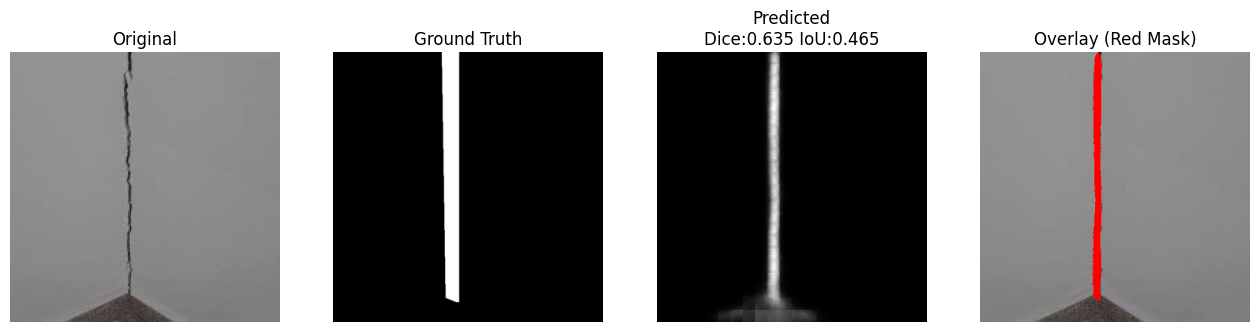

✅ Visualizing a_5_38_png_jpg.rf.9efb00a4109110c36f0086f2fd7e5dcc.jpg


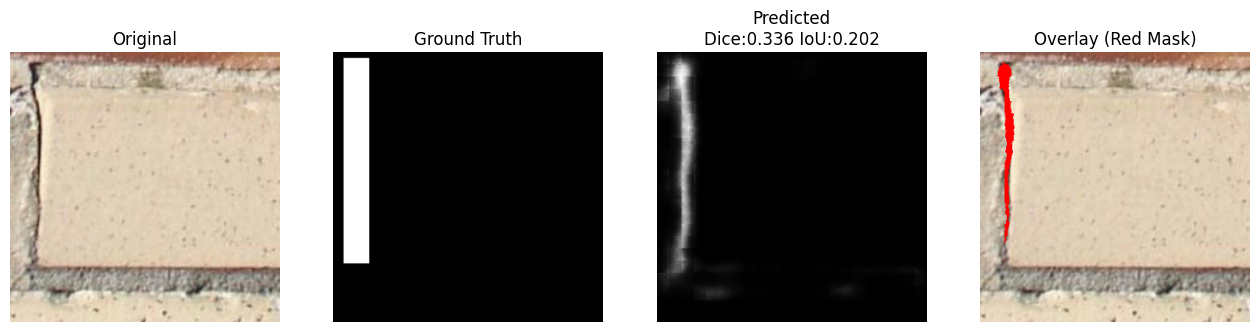

In [9]:
import random
from pathlib import Path

print("\n🔍 Evaluating improved crack masks (safe version)...")

crack_valid = Path("/content/data/cracks/valid")
mask_dir = crack_valid / "masks_bbox"

imgs = [img for img in crack_valid.glob("*.jpg") if (mask_dir / (img.stem + ".png")).exists()]

if len(imgs) == 0:
    raise RuntimeError("❌ No matching crack masks found! Please verify /content/data/cracks/valid/masks_bbox/ exists.")

random_samples = random.sample(imgs, min(2, len(imgs)))

for img_path in random_samples:
    mask_path = mask_dir / (img_path.stem + ".png")
    print(f"✅ Visualizing {img_path.name}")
    visualize_prediction(img_path, mask_path, "segment crack")


# Final Evaluation (mIoU & Dice)

Compute segmentation metrics:

per-dataset

average inference time

model size


In [25]:
import torch, time
import numpy as np
from PIL import Image
from tqdm import tqdm
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
from torchvision import transforms
from pathlib import Path
import os, gc

# Load fine-tuned model
model_path = "/content/clipseg-finetuned"
processor = CLIPSegProcessor.from_pretrained(model_path)
model = CLIPSegForImageSegmentation.from_pretrained(model_path).to("cuda").eval()

resize = transforms.Resize((352, 352))

def dice_score(pred, gt):
    pred = pred > 0.5
    gt = gt > 0.5
    inter = (pred & gt).sum()
    union = pred.sum() + gt.sum()
    return (2.0 * inter) / union if union != 0 else 1.0

def miou(pred, gt):
    pred = pred > 0.5
    gt = gt > 0.5
    inter = (pred & gt).sum()
    union = (pred | gt).sum()
    return inter / union if union != 0 else 1.0

def evaluate_dataset(dataset_dir, prompt, mask_subdir="masks"):
    imgs = list(Path(dataset_dir).glob("*.jpg"))
    ious, dices, times = [], [], []

    for img_path in tqdm(imgs, desc=f"Evaluating {prompt}"):
        mask_path = Path(dataset_dir) / mask_subdir / (img_path.stem + ".png")
        if not mask_path.exists():
            continue
        image = Image.open(img_path).convert("RGB")
        gt_mask = Image.open(mask_path).convert("L")
        gt = np.array(resize(gt_mask)) / 255.0

        inputs = processor(text=prompt, images=image, return_tensors="pt").to("cuda")

        start = time.time()
        with torch.no_grad():
            pred_mask = torch.sigmoid(model(**inputs).logits).cpu().squeeze().numpy()
        end = time.time()

        ious.append(miou(pred_mask, gt))
        dices.append(dice_score(pred_mask, gt))
        times.append(end - start)

    return {
        "prompt": prompt,
        "count": len(ious),
        "mean_iou": np.mean(ious),
        "mean_dice": np.mean(dices),
        "avg_time": np.mean(times)
    }

# Evaluate both datasets
cracks_metrics = evaluate_dataset("/content/data/cracks/valid", "segment crack", mask_subdir="masks_bbox")
drywall_metrics = evaluate_dataset("/content/data/drywall/valid", "segment taping area", mask_subdir="masks")

# Model size
model_size_mb = sum(os.path.getsize(os.path.join(dp, f)) for dp, dn, filenames in os.walk(model_path) for f in filenames) / (1024 * 1024)

# Results table
import pandas as pd
df = pd.DataFrame([cracks_metrics, drywall_metrics])
df["model_size_MB"] = model_size_mb
df = df[["prompt", "mean_iou", "mean_dice", "avg_time", "model_size_MB", "count"]]

print("\n✅ Final Evaluation Summary:")
print(df.to_markdown(index=False))



Evaluating segment taping area: 100%|██████████| 202/202 [00:21<00:00,  9.54it/s]


✅ Final Evaluation Summary:
| prompt              |   mean_iou |   mean_dice |   avg_time |   model_size_MB |   count |
|:--------------------|-----------:|------------:|-----------:|----------------:|--------:|
| segment crack       |   0.281341 |    0.382053 |  0.070965  |         578.557 |     201 |
| segment taping area |   0.537419 |    0.667907 |  0.0633626 |         578.557 |     202 |


# Saving Predictions for All Validation Images

Generate prediction PNG masks for every validation image:
Filenames follow required format:

<image_stem>__segment_crack.png

<image_stem>__segment_taping_area.png

Resized to original resolution, binary mask {0,255}.

In [17]:

import os, time, random
import numpy as np
from pathlib import Path
from PIL import Image
import torch

SEED = 42
import random, numpy as np
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print("Seeds set to", SEED)

# 2) Paths & model
MODEL_PATH = "/content/clipseg-finetuned"
OUT_BASE = Path("/content/predictions")
OUT_BASE.mkdir(exist_ok=True)

from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
processor = CLIPSegProcessor.from_pretrained(MODEL_PATH)
model = CLIPSegForImageSegmentation.from_pretrained(MODEL_PATH).to("cuda").eval()

def predict_and_save_for_folder(images_folder, masks_subdir, prompt, out_subfolder):
    images_folder = Path(images_folder)
    out_dir = OUT_BASE / out_subfolder
    out_dir.mkdir(parents=True, exist_ok=True)
    images = sorted(images_folder.glob("*.jpg")) + sorted(images_folder.glob("*.png")) + sorted(images_folder.glob("*.jpeg"))
    count = 0
    t_total = 0.0
    for img_path in images:

        pil = Image.open(img_path).convert("RGB")
        W, H = pil.size

        # processor + model
        inputs = processor(text=prompt, images=pil, return_tensors="pt").to("cuda")
        t0 = time.time()
        with torch.no_grad():
            logits = model(**inputs).logits  # shape [1, Hout, Wout]
            pred = torch.sigmoid(logits).cpu().squeeze().numpy()
        t1 = time.time()
        t_total += (t1 - t0)
        # resize predicted mask to original image size (use bilinear)
        pred_resized = Image.fromarray((pred * 255).astype(np.uint8)).resize((W, H), resample=Image.BILINEAR)
        pred_np = np.array(pred_resized).astype(np.float32) / 255.0

        # threshold to binary 0/255
        binary = (pred_np > 0.5).astype(np.uint8) * 255
        out_name = f"{img_path.stem}__{prompt.replace(' ', '_')}.png"
        out_path = out_dir / out_name
        Image.fromarray(binary).convert("L").save(out_path, compress_level=1)
        count += 1

    avg_time = (t_total / count) if count > 0 else 0.0
    return count, avg_time, out_dir

print("Running predictions and saving...")

cracks_valid_folder = "/content/data/cracks/valid"
drywall_valid_folder = "/content/data/drywall/valid"

c1, t1, out1 = predict_and_save_for_folder(cracks_valid_folder, "masks_bbox", "segment crack", "cracks_valid_segment_crack")
c2, t2, out2 = predict_and_save_for_folder(drywall_valid_folder, "masks", "segment taping area", "drywall_valid_segment_taping_area")

print(f"\nSaved {c1} crack predictions to: {out1}  (avg inference {t1:.4f}s)")
print(f"Saved {c2} drywall predictions to: {out2}  (avg inference {t2:.4f}s)")

print("\nExamples saved (first 5 each):")
print(list(out1.glob("*.png"))[:5])
print(list(out2.glob("*.png"))[:5])


Seeds set to 42
Running predictions and saving...

Saved 201 crack predictions to: /content/predictions/cracks_valid_segment_crack  (avg inference 0.0441s)
Saved 202 drywall predictions to: /content/predictions/drywall_valid_segment_taping_area  (avg inference 0.0445s)

Examples saved (first 5 each):
[PosixPath('/content/predictions/cracks_valid_segment_crack/images24_jpg.rf.440a4c156d22bfce7b4f0d78f607295e__segment_crack.png'), PosixPath('/content/predictions/cracks_valid_segment_crack/image_jpeg_jpg.rf.5854b2f7f2aeca54b672c1d26da0d364__segment_crack.png'), PosixPath('/content/predictions/cracks_valid_segment_crack/crack209_jpg.rf.639692eb13b81813896c89a83be310d8__segment_crack.png'), PosixPath('/content/predictions/cracks_valid_segment_crack/image9_jpeg_jpg.rf.728cf04a6e8849edbd02462b594c54fa__segment_crack.png'), PosixPath('/content/predictions/cracks_valid_segment_crack/images187_jpg.rf.cc350618182f26ba0258d11388f51ee4__segment_crack.png')]
[PosixPath('/content/predictions/drywall_

# Showing Saved Examples (Original | GT | Pred | Overlay)

Show 5 randomly selected predictions with:

Original

Ground Truth

Model Prediction

Overlay


🔍 Showing 5 random examples for segment crack...


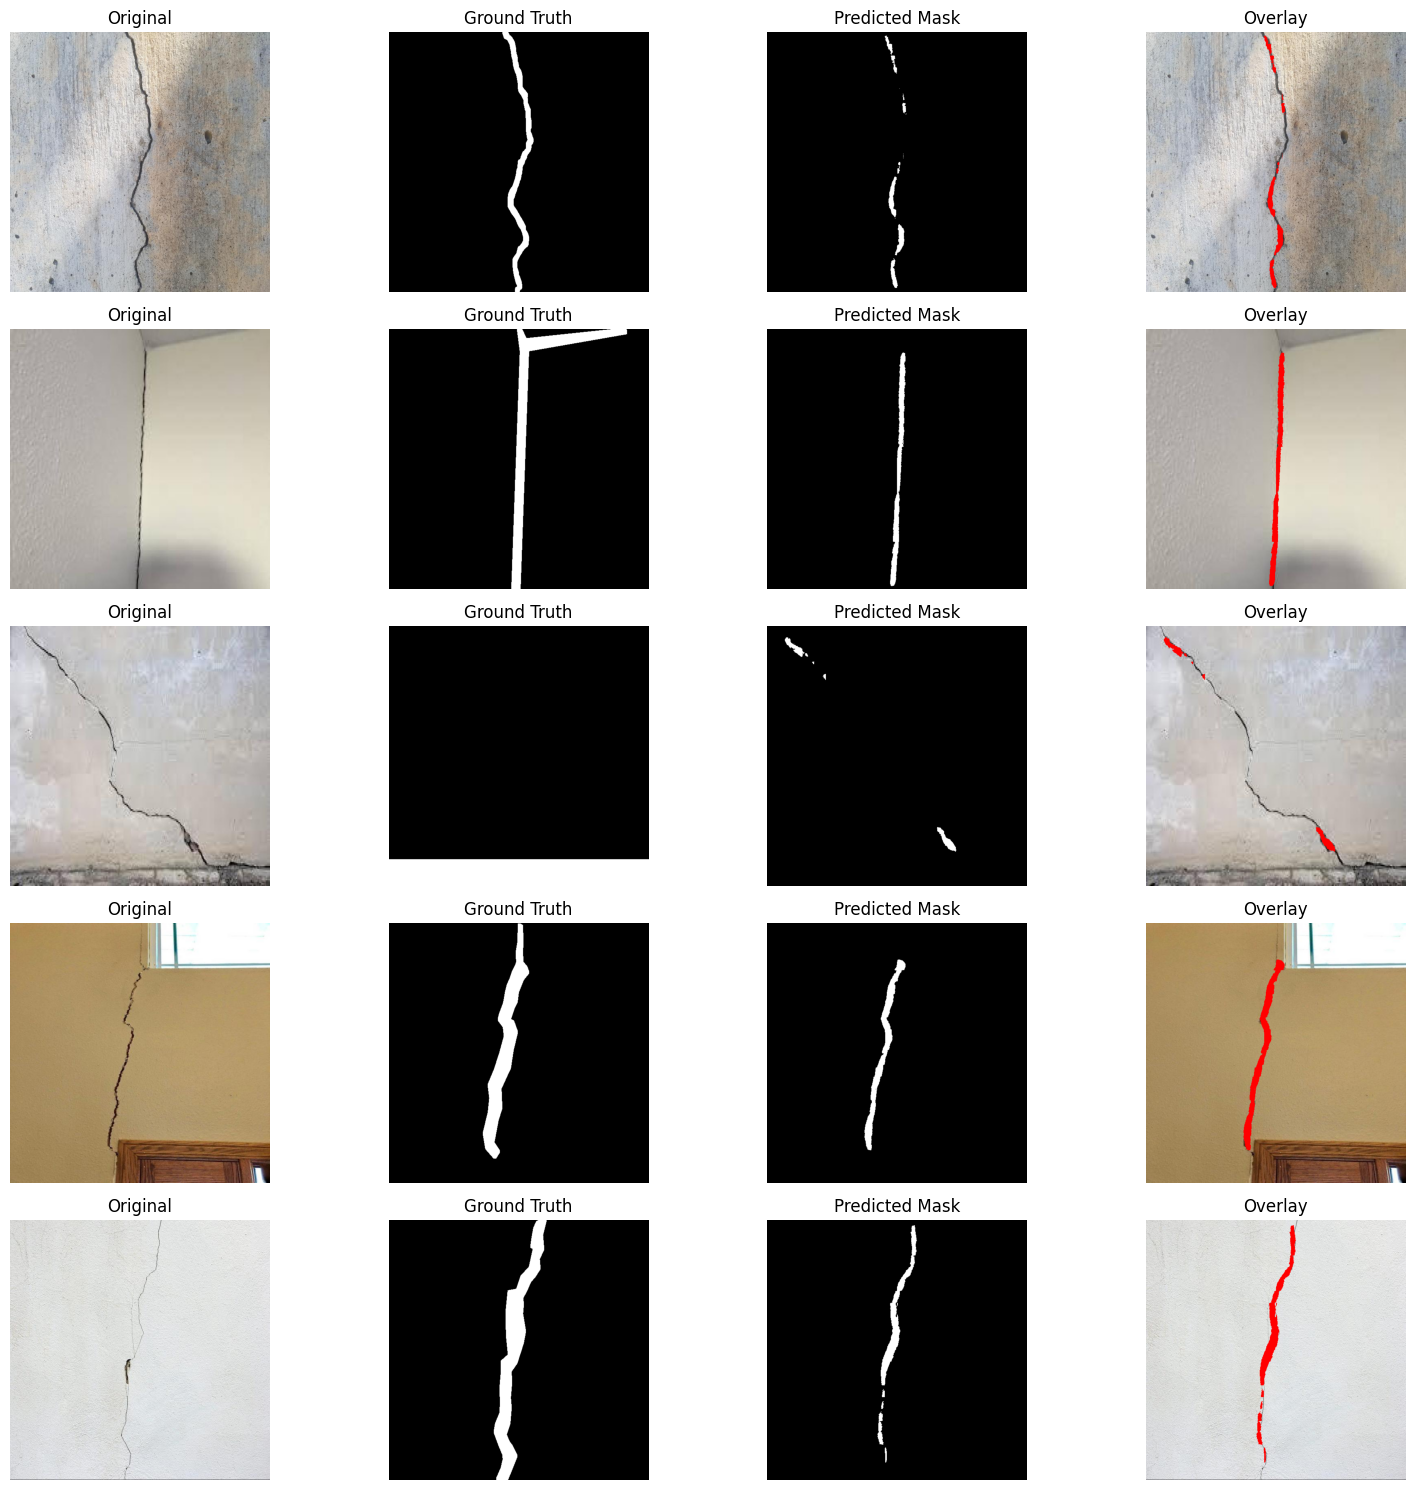


🔍 Showing 5 random examples for segment taping area...


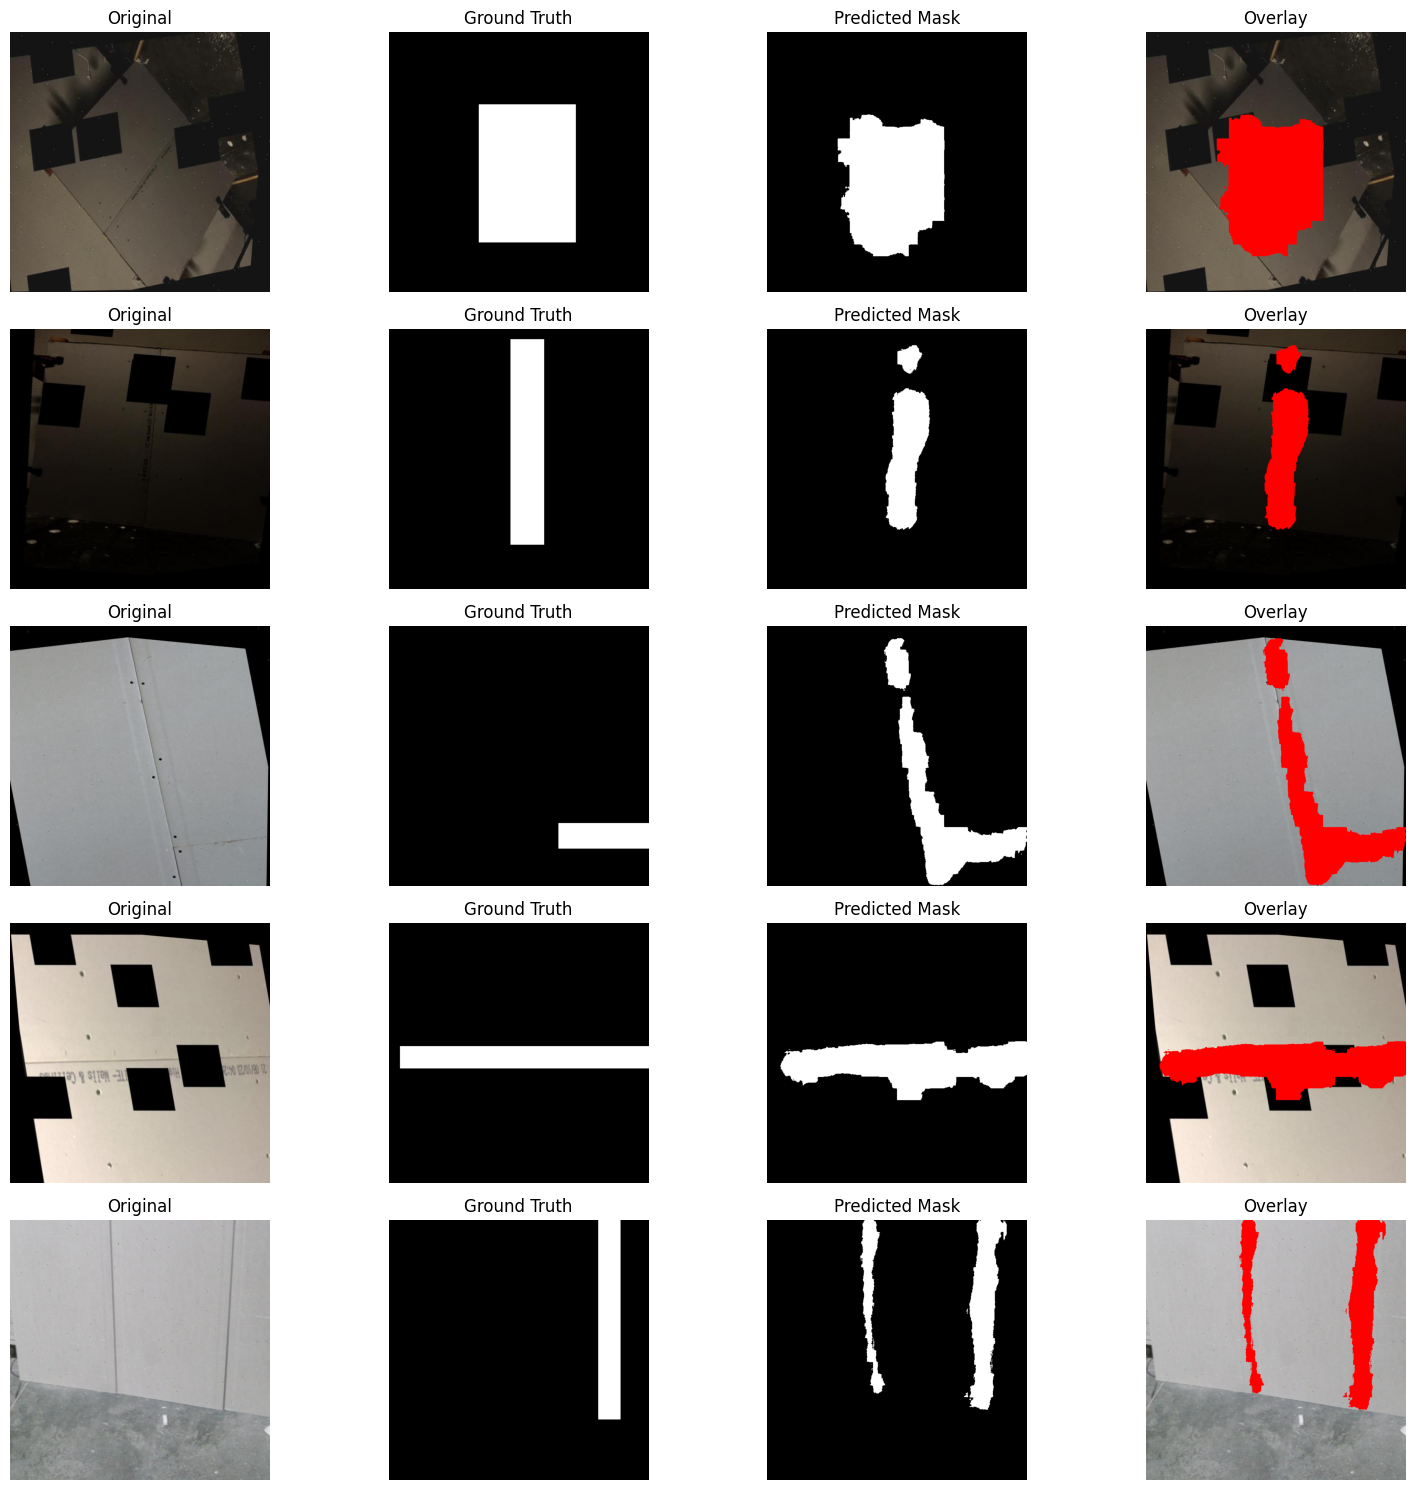

In [24]:

import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


# Prediction folders
crack_pred_dir = Path("/content/predictions/cracks_valid_segment_crack")
drywall_pred_dir = Path("/content/predictions/drywall_valid_segment_taping_area")

# Corresponding original image folders
crack_img_dir = Path("/content/data/cracks/valid")
drywall_img_dir = Path("/content/data/drywall/valid")

# Ground truth mask folders
crack_gt_dir = Path("/content/data/cracks/valid/masks_bbox")
drywall_gt_dir = Path("/content/data/drywall/valid/masks")


def show_examples_with_gt(pred_dir, img_dir, gt_dir, prompt_label, num_samples=5):
    preds = sorted(list(pred_dir.glob("*.png")))
    if len(preds) == 0:
        print(f"❌ No predictions found in {pred_dir}")
        return

    print(f"\n🔍 Showing {num_samples} random examples for {prompt_label}...")
    samples = random.sample(preds, min(num_samples, len(preds)))

    plt.figure(figsize=(16, num_samples * 3))

    for i, pred_path in enumerate(samples):
        # Extract image stem
        stem = pred_path.name.split("__")[0]

        # Find original image
        img_path = None
        for ext in ["jpg", "jpeg", "png"]:
            test_path = img_dir / f"{stem}.{ext}"
            if test_path.exists():
                img_path = test_path
                break

        if img_path is None:
            print(f"⚠️ Could not find original image for {stem}")
            continue

        # Find ground truth mask
        gt_path = gt_dir / f"{stem}.png"
        if not gt_path.exists():
            print(f"⚠️ No GT mask found for {stem}")
            continue

        # Load images
        img = Image.open(img_path).convert("RGB")
        gt_mask = Image.open(gt_path).convert("L")
        pred_mask = Image.open(pred_path).convert("L")

        img_np = np.array(img)
        gt_np = np.array(gt_mask) / 255.0
        pred_np = np.array(pred_mask) / 255.0

        # Create overlay for predicted
        overlay = img_np.copy()
        overlay[pred_np > 0.5] = [255, 0, 0]

        # Display: Original | GT | Pred | Overlay
        plt.subplot(len(samples), 4, 4*i + 1)
        plt.imshow(img_np)
        plt.title("Original")
        plt.axis("off")

        plt.subplot(len(samples), 4, 4*i + 2)
        plt.imshow(gt_np, cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(len(samples), 4, 4*i + 3)
        plt.imshow(pred_np, cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.subplot(len(samples), 4, 4*i + 4)
        plt.imshow(overlay)
        plt.title("Overlay")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# Show 5 Crack examples WITH GT
show_examples_with_gt(
    crack_pred_dir,
    crack_img_dir,
    crack_gt_dir,
    "segment crack"
)

# Show 5 Drywall examples WITH GT
show_examples_with_gt(
    drywall_pred_dir,
    drywall_img_dir,
    drywall_gt_dir,
    "segment taping area"
)


# Interactive Testing (Upload Image + Type Prompt)

Upload a custom image and run inference using any text prompt:

“segment crack”

“segment taping area”

Outputs:
original
predicted mask
overlay